# Use stain normalization to test the filters for feature extraction

In [1]:
import numpy as np
import cv2
from matplotlib import pyplot as plt
from skimage.filters import threshold_isodata, threshold_minimum, threshold_li, threshold_mean
from skimage.morphology import disk, binary_closing
from skimage.segmentation import clear_border

from __future__ import print_function

import cv2

import histomicstk as htk

import numpy as np
import scipy as sp

import skimage.io
import skimage.measure
import skimage.color

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline

#Some nice default configuration for plots
plt.rcParams['figure.figsize'] = 5, 5
plt.rcParams['image.cmap'] = 'gray'
titlesize = 24

def plot_comparison(original, filtered, filter_name):

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(8, 4), sharex=True,
                                   sharey=True)
    ax1.imshow(original, cmap=plt.cm.gray)
    ax1.set_title('original')
    ax1.axis('off')
    ax2.imshow(filtered, cmap=plt.cm.gray)
    ax2.set_title(filter_name)
    ax2.axis('off')

def StainNormalization(image):
    ############### INPUT RGB IMAGE #######################
    global img
    
    img = cv2.imread(image, 1)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # create stain to color map
    stain_color_map = htk.preprocessing.color_deconvolution.stain_color_map
    #print('stain_color_map:', stain_color_map, sep='\n')

    # specify stains of input image
    stains = ['hematoxylin',  # nuclei stain
          'eosin',        # cytoplasm stain
          'null']         # set to null if input contains only two stains
    
    I_0 = 255

    w_est = htk.preprocessing.color_deconvolution.rgb_separate_stains_macenko_pca(img, I_0)

    # Perform color deconvolution
    deconv_result = htk.preprocessing.color_deconvolution.color_deconvolution(img, w_est, I_0)
    
    global H, cl_img, dst, thresh1, inverted, opening
    
    H = deconv_result.Stains[:, :, 1]
    
    clahe = cv2.createCLAHE(clipLimit = 2, tileGridSize=(8,8))
    cl_img = clahe.apply(H)
    
    dst = cv2.fastNlMeansDenoising(cl_img, None, 20, 7, 21)
    
    thresh = threshold_li(dst)
    binary = dst > thresh
    
    inverted = ~binary
    inverted = inverted.astype(np.uint8)
    inverted = inverted*255
    
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(13,13))
    opening = cv2.morphologyEx(inverted, cv2.MORPH_OPEN, kernel)
    
    #Remove edge touching grains
    opening = clear_border(opening) 
        
    # sure background area
    kernel = cv2.getStructuringElement(cv2.MORPH_ELLIPSE,(5,5))
    sure_bg = cv2.dilate(opening,kernel,iterations=2)

    # Finding sure foreground area
    dist_transform = cv2.distanceTransform(opening,cv2.DIST_L2,5)
    ret, sure_fg = cv2.threshold(dist_transform,0.25*dist_transform.max(),255,0)

    # Finding unknown region
    sure_fg = np.uint8(sure_fg)
    unknown = cv2.subtract(sure_bg,sure_fg)
    #plt.imsave('unknown.png', unknown,cmap='gray')
    
    global markers
    
    # Marker labelling
    ret, markers = cv2.connectedComponents(sure_fg)

    # Add one to all labels so that sure background is not 0, but 1
    markers = markers+10

    # Now, mark the region of unknown with zero
    markers[unknown==255] = 0

    #Let us color boundaries in yellow. 
    #Remember that watershed assigns boundaries a value of -1
    
    #image = cv2.imread("Abnormal variation in nuclear shape/1.png")

    markers = cv2.watershed(img,markers)

    #Let us color boundaries in yellow. 
    #Remember that watershed assigns boundaries a value of -1 
    
    img[markers == -1] = [255,255,0]
    
    #img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    fig = plt.imshow(img)
    plt.axis('off')
    #plt.show()    

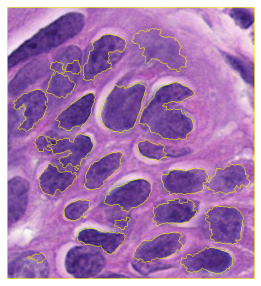

In [2]:
StainNormalization("Abnormal Variation in Nuclear Shape/1.png") 

(-0.5, 430.5, 473.5, -0.5)

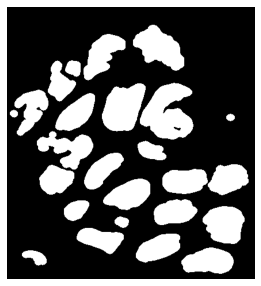

In [3]:
plt.imshow(opening)
plt.axis("off")

The binarized images is used for feature extraction

# RegionProps

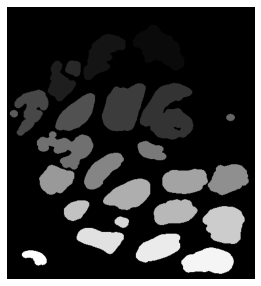

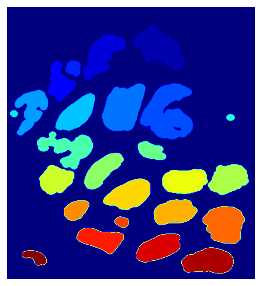

In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from glob import glob
from skimage.io import imread, imshow
from skimage.color import rgb2gray
from skimage.measure import label, regionprops, regionprops_table
from skimage.filters import threshold_otsu
from skimage.morphology import area_closing, area_opening

label_im = label(opening)
regions = regionprops(label_im)

plt.imshow(label_im)
plt.axis("off")
plt.show()

plt.imshow(label_im,cmap='jet')
plt.axis("off")
plt.show()

In [5]:
properties = ['area', 'perimeter', 'mean_intensity', 'eccentricity']
pd.DataFrame(regionprops_table(label_im, dst, 
                               properties=properties)).head(10)

area   perimeter  mean_intensity  eccentricity
0  4123  287.220346       71.043172      0.823797
1  3124  269.178716       57.240397      0.887236
2  1904  202.693434       77.886555      0.781381
3   594   91.597980       75.843434      0.363010
4  5872  449.730014       64.990123      0.553170
5  4558  277.036580       58.542782      0.735453
6  2589  299.605122       59.999614      0.806934
7  2677  217.622366       45.010459      0.884007
8   143   42.041631       74.300699      0.439860
9   147   42.627417       98.795918      0.578718

In [16]:
features =  pd.DataFrame(regionprops_table(label_im, dst,properties=properties))

In [15]:
print(features)

    area  eccentricity   perimeter  intensity_mean
0   4123      0.823797  287.220346       71.043172
1   3124      0.887236  269.178716       57.240397
2   1904      0.781381  202.693434       77.886555
3    594      0.363010   91.597980       75.843434
4   5872      0.553170  449.730014       64.990123
5   4558      0.735453  277.036580       58.542782
6   2589      0.806934  299.605122       59.999614
7   2677      0.884007  217.622366       45.010459
8    143      0.439860   42.041631       74.300699
9    147      0.578718   42.627417       98.795918
10  3291      0.828059  369.646753       61.581890
11  1159      0.850507  142.225397       65.036238
12  2350      0.913948  208.693434       68.114468
13  2724      0.721690  211.137085       60.748532
14  2220      0.611891  183.823376       52.805405
15  2795      0.847834  212.367532       57.901252
16  2986      0.837473  222.551299       51.481581
17  2564      0.837885  205.338095       55.689938
18  1143      0.756302  129.053

<b> For the illustration of identified nuclei via plotly </b>

In [8]:
import plotly
import plotly.express as px
import plotly.graph_objects as go
from skimage import data, filters, measure, morphology
from skimage.io import imread

img = imread("Abnormal Variation in Nuclear Shape/1.png", as_gray = True)

# Binary image, post-process the binary mask and compute labels

labels = measure.label(opening)

fig = px.imshow(img, binary_string=True)
fig.update_traces(hoverinfo='skip') # hover is only for label info

props = measure.regionprops(labels, img)
properties = ['area', 'eccentricity', 'perimeter', 'intensity_mean']


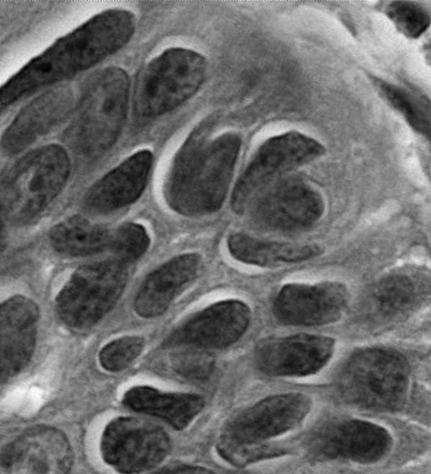

In [9]:
# For each label, add a filled scatter trace for its contour,
# and display the properties of the label in the hover of this trace.
for index in range(1, labels.max()):
    label_i = props[index].label
    contour = measure.find_contours(labels == label_i, 0.5)[0]
    y, x = contour.T
    hoverinfo = ''
    for prop_name in properties:
        hoverinfo += f'<b>{prop_name}: {getattr(props[index], prop_name):.2f}</b><br>'
    fig.add_trace(go.Scatter(
        x=x, y=y, name=label_i,
        mode='lines', fill='toself', showlegend=False,
        hovertemplate=hoverinfo, hoveron='points+fills'))

plotly.io.show(fig)

## Function to get properties

In [17]:
def get_properties():
    properties = ['area', 'perimeter', 'eccentricity', 'mean_intensity']
    dataframe = pd.DataFrame(columns=properties)
    labeled = label(opening)
    regions = regionprops(labeled)
    data = pd.DataFrame(regionprops_table(labeled, dst,
                                          properties=properties))
    data = data[(data.index != 0) & (data.area > 100)]
    dataframe = pd.concat([dataframe, data])
    return dataframe

In [18]:
A = get_properties()
print("The shape of the dataframe is: ", A.shape)
A.head()

The shape of the dataframe is:  (24, 4)


area   perimeter eccentricity mean_intensity
1  3124  269.178716     0.887236      57.240397
2  1904  202.693434     0.781381      77.886555
3   594    91.59798      0.36301      75.843434
4  5872  449.730014      0.55317      64.990123
5  4558   277.03658     0.735453      58.542782

In [20]:
A['roundness circularity'] = 4*np.pi*(A['area']/A['perimeter']**2)

A.head()

area   perimeter eccentricity mean_intensity roundness circularity
1  3124  269.178716     0.887236      57.240397              0.541801
2  1904  202.693434     0.781381      77.886555              0.582368
3   594    91.59798      0.36301      75.843434              0.889661
4  5872  449.730014      0.55317      64.990123              0.364831
5  4558   277.03658     0.735453      58.542782              0.746294

## To loop the operation over files

In [22]:
import os
from natsort import natsorted, ns #library for sorting

path = "D://OneDrive - Universiti Malaya//Work//Desktop//UM Master of Data Science//Sem 2//0 - Research Project//Data//Nuclear Hyperchromasia"
dfs = []

for count, file in enumerate(natsorted(os.listdir(path), alg=ns.PATH | ns.IGNORECASE)):
    if file.endswith(".png"):
        f = os.path.join(path, file)
        print(f)

D://OneDrive - Universiti Malaya//Work//Desktop//UM Master of Data Science//Sem 2//0 - Research Project//Data//Nuclear Hyperchromasia\1.png
D://OneDrive - Universiti Malaya//Work//Desktop//UM Master of Data Science//Sem 2//0 - Research Project//Data//Nuclear Hyperchromasia\2.png
D://OneDrive - Universiti Malaya//Work//Desktop//UM Master of Data Science//Sem 2//0 - Research Project//Data//Nuclear Hyperchromasia\3.png
D://OneDrive - Universiti Malaya//Work//Desktop//UM Master of Data Science//Sem 2//0 - Research Project//Data//Nuclear Hyperchromasia\4.png
D://OneDrive - Universiti Malaya//Work//Desktop//UM Master of Data Science//Sem 2//0 - Research Project//Data//Nuclear Hyperchromasia\5.png
D://OneDrive - Universiti Malaya//Work//Desktop//UM Master of Data Science//Sem 2//0 - Research Project//Data//Nuclear Hyperchromasia\6.png
D://OneDrive - Universiti Malaya//Work//Desktop//UM Master of Data Science//Sem 2//0 - Research Project//Data//Nuclear Hyperchromasia\7.png
D://OneDrive - Unive

<b> The iteration does follow the alphanumeric sequence now </b>

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log



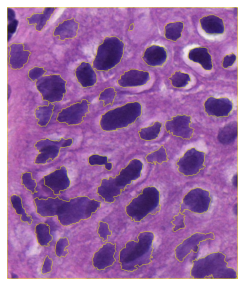

In [30]:
import os

path = "D://OneDrive - Universiti Malaya//Work//Desktop//UM Master of Data Science//Sem 2//0 - Research Project//Data//Nuclear Hyperchromasia"
dfs = []

for count, file in enumerate(natsorted(os.listdir(path), alg=ns.PATH | ns.IGNORECASE)):
    if file.endswith(".png"):
        f = os.path.join(path, file)
        StainNormalization(f)
        df = get_properties()
        df['roundness circularity'] = 4*np.pi*(df['area']/df['perimeter']**2)
        dfs.append(df)
        
df_final = pd.concat(dfs, ignore_index=True)

In [31]:
dfs

[  area  perimeter eccentricity mean_intensity roundness circularity
 1  121  38.627417     0.452998      84.239669               1.01907,
   area  perimeter eccentricity mean_intensity roundness circularity
 1  228  54.526912      0.61161      54.745614              0.963658
 2  412  82.911688      0.88086      58.347087               0.75314
 3  354  84.669048     0.884185      58.940678              0.620531,
    area   perimeter eccentricity mean_intensity roundness circularity
 1   252   57.355339     0.669146      88.428571              0.962637
 2   207   51.698485     0.516207      75.309179               0.97325
 3   237   55.112698     0.552789      64.021097              0.980516
 4   239   55.355339     0.485041     101.615063              0.980141
 5  8378  489.185858     0.713306      60.491287              0.439949
 6   913  131.539105     0.468538      71.398686              0.663088,
      area   perimeter eccentricity mean_intensity roundness circularity
 1    4131  2

<b> Appended df still has indexes in between. <b/>

In [32]:
df_final

area   perimeter eccentricity mean_intensity roundness circularity
0      121   38.627417     0.452998      84.239669               1.01907
1      228   54.526912      0.61161      54.745614              0.963658
2      412   82.911688      0.88086      58.347087               0.75314
3      354   84.669048     0.884185      58.940678              0.620531
4      252   57.355339     0.669146      88.428571              0.962637
...    ...         ...          ...            ...                   ...
1722  1511  154.367532     0.804996      60.663137              0.796824
1723  3425  231.178716     0.787937      43.011387              0.805332
1724  5595  356.534055     0.779187      47.838606              0.553105
1725  1123  134.811183     0.815129      48.237756              0.776493
1726   155   44.041631     0.537058      24.477419              1.004187

[1727 rows x 5 columns]

<b> Final dataframe removed the indexes. </b>

In [33]:
 df_final.to_csv('Hyperchromasia.csv', index=False) # to save the dataframe in csv

## Final Operation (Loop over all images)

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log

c:\users\teoh\histomicstk\h

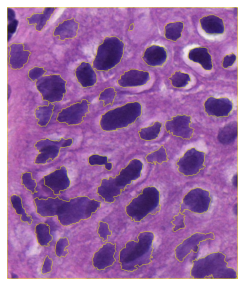

In [34]:
import os

path = "D://OneDrive - Universiti Malaya//Work//Desktop//UM Master of Data Science//Sem 2//0 - Research Project//Data//Nuclear Hyperchromasia"
dfs = []

for count, file in enumerate(natsorted(os.listdir(path), alg=ns.PATH | ns.IGNORECASE)):
    if file.endswith(".png"):
        StainNormalization(f)
        df = get_properties()
        df['roundness circularity'] = 4*np.pi*(df['area']/df['perimeter']**2)
        dfs.append(df)
        
df_final = pd.concat(dfs, ignore_index=True)
df_final.to_csv('Hyperchromasia.csv', index=False)

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log

c:\users\teoh\histomicstk\histomicstk\preprocessing\color_conversion\rgb_to_sda.py:48: RuntimeWarning:

divide by zero encountered in log

c:\users\teoh\histomicstk\h

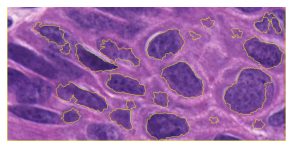

In [35]:
import os

path = "D://OneDrive - Universiti Malaya//Work//Desktop//UM Master of Data Science//Sem 2//0 - Research Project//Data//Final//AbnormalVariationInNuclearShape"
dfs = []

for count, file in enumerate(natsorted(os.listdir(path), alg=ns.PATH | ns.IGNORECASE)):
    if file.endswith(".png"):
        f = os.path.join(path, file)
        StainNormalization(f)
        df = get_properties()
        df['roundness circularity'] = 4*np.pi*(df['area']/df['perimeter']**2)
        dfs.append(df)
        
df_final = pd.concat(dfs, ignore_index=True)
df_final.to_csv('Abnormal Shape.csv', index=False)

## For Normal Images

Due to the large variety of images and shortage of time, the nuclei of normal images are marked.

No stain normalization is needed, just apply direct binarization.

In [40]:
def get_properties_normal():
    properties = ['area', 'perimeter', 'eccentricity', 'mean_intensity']
    dataframe = pd.DataFrame(columns=properties)
    labeled = label(inverted)
    regions = regionprops(labeled)
    data = pd.DataFrame(regionprops_table(labeled, img,
                                          properties=properties))
    data = data[(data.index != 0) & (data.area > 100)]
    dataframe = pd.concat([dataframe, data])
    return dataframe

def binarize(image):
    ############### INPUT RGB IMAGE #######################
    
    img = cv2.imread(image)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    th, im_th = cv2.threshold(gray,30,255,cv2.THRESH_BINARY)
    
    global inverted
    
    inverted = ~im_th
    
    fig = plt.imshow(inverted)
    plt.axis('off')
    #plt.show()    

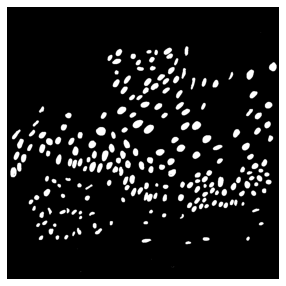

In [41]:
dfs = []

for n in range(1, 33):
    img = cv2.imread(f"Final/Normal/{str(n)}.png")
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    binarize(f"Final/Normal/{str(n)}.jpg")

    df = get_properties_normal()
    df['roundness circularity'] = 4*np.pi*(df['area']/df['perimeter']**2)
    dfs.append(df)

In [42]:
df_final = pd.concat(dfs, ignore_index=True)
df_final.to_csv('Normal.csv', index=False)